## Agenda

The idea of this project is to create a model that, given an image of a Red Blood Cell, will be able to predict whether it is infected with Malaria or not!

We would be using a lot of custom images containing infected and uninfected images of RBC's and using that, we are going to predict whether an unseen image contains the infection or not.


## The Data

The images have been organized within the `DATA` directory containing separate folders for 'Train' & 'Test' with each containing further sub-folders with desired labels -- Infected & Uninfected

And a total of 27,558 images.

**ORIGINAL DATA SOURCE:**

Acknowledgements:
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

### 1. Necessary imports

In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sb

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as img

%matplotlib inline

### 2. Prepare and visualize the data

**The cell images have been extracted and kept within the `./DATA/cell_images/` folder.**

In [19]:
data_dir = '.DATA/cell_images/'

In [20]:
os.listdir(data_dir)

['test', 'train']

In [21]:
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'

os.listdir(train_dir), os.listdir(test_dir)

(['Uninfected', 'Parasitized'], ['Uninfected', 'Parasitized'])

**Checkout a single image from the Train set:**

In [23]:
image1 = os.listdir(train_dir + 'Parasitized/')[0]
image1

'C132P93ThinF_IMG_20151004_151941_cell_10.png'

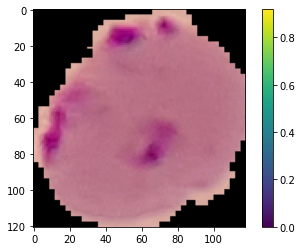

In [24]:
plt.imshow(img.imread(train_dir + 'Parasitized/' + image1))
plt.colorbar()

**Image from the Test set:**

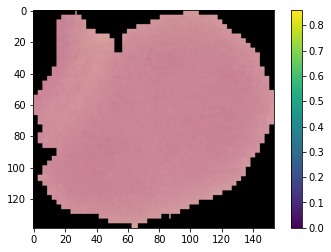

In [25]:
plt.imshow(img.imread(test_dir + 'Uninfected/' + os.listdir(test_dir + 'Uninfected/')[0]))
plt.colorbar()

**Check the avg dimensions of the images such that its easier to map the images to a fixed shape for modelling:**

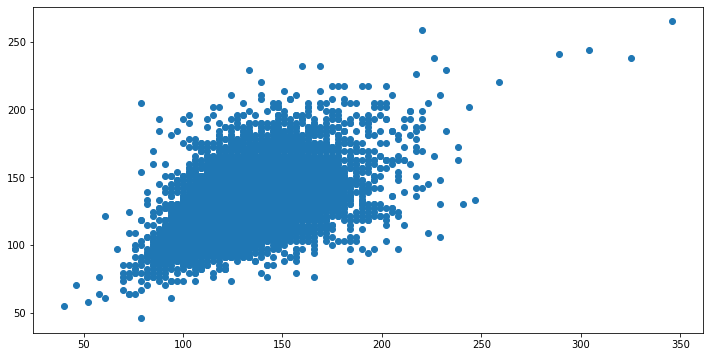

In [26]:
dim1, dim2 = [],[]

for i in os.listdir(train_dir + 'Parasitized/'):
    image = img.imread(train_dir + 'Parasitized/' + i)
    d1, d2, color = image.shape
    dim1.append(d1)
    dim2.append(d2)
    
plt.figure(figsize = (12, 6))
plt.scatter(dim1, dim2)

As seen above, we can see bulk of the points to be centered around the 100 - 170 mark on both axes, so checking the exact mean dimensions:

In [27]:
np.mean(dim1), np.mean(dim2), color

(132.8975879477522, 132.29778027085504, 3)

As seen mean for both dimensions is around the 130 mark; therefore, it would be good to reshape the images to (130 x 130 x 3)

In [28]:
image_shape = (130, 130, 3)

### 3. Image data generation and manipulation

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
image_gen = ImageDataGenerator(rotation_range = 20,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.3,
                               horizontal_flip = True,
                               vertical_flip = True,
                               rescale = 1 / 255,
                               fill_mode = 'nearest')

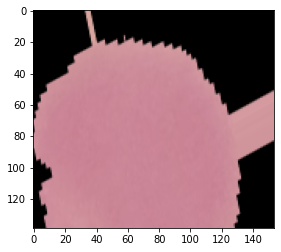

In [31]:
plt.imshow(image_gen.random_transform(img.imread(test_dir + 'Uninfected/' + os.listdir(test_dir + 'Uninfected/')[0])))

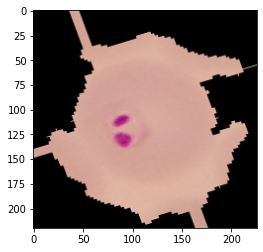

In [32]:
plt.imshow(image_gen.random_transform(img.imread(test_dir + 'Parasitized/' + os.listdir(test_dir + 'Parasitized/')[0])))

As seen in the images above, Image Data Generator is correctly applying the augmentation techniques as defined earlier....

**We will now generate the Training & Testing image data to feed into our CNN model:**

In [33]:
train_data_gen = image_gen.flow_from_directory(train_dir,
                                               target_size = image_shape[:2],
                                               batch_size = 64,
                                               color_mode = 'rgb',
                                               class_mode = 'binary',
                                               shuffle = True)

Found 24958 images belonging to 2 classes.


In [34]:
test_data_gen = image_gen.flow_from_directory(test_dir,
                                              target_size = image_shape[:2],
                                              batch_size = 64,
                                              color_mode = 'rgb',
                                              class_mode = 'binary',
                                              shuffle = False)

Found 2600 images belonging to 2 classes.


In [35]:
train_data_gen.class_indices, test_data_gen.class_indices

({'Parasitized': 0, 'Uninfected': 1}, {'Parasitized': 0, 'Uninfected': 1})

### 4. Create & Train the model

In [79]:
tf.keras.backend.clear_session()

img_model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(filters = 32, kernel_size = (2, 2), strides = (1, 1), padding = 'valid',
                                       activation = 'relu', input_shape = image_shape),
                tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (1, 1)),
    
                tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same',
                                       activation = 'relu'),
                tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (1, 1)),

                tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same',
                                       dilation_rate = (1, 1), activation = 'relu'),
                tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (1, 1)),
    
    
                tf.keras.layers.Flatten(),
    
    
                tf.keras.layers.Dense(128, activation = 'relu'),
                tf.keras.layers.Dropout(0.5),
    
                tf.keras.layers.Dense(1, activation = 'sigmoid')
])


img_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [80]:
img_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 129, 129, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 64)     0

**Train the model:**

In [81]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, 
                                              restore_best_weights = True)

history = img_model.fit(train_data_gen, epochs = 40, validation_data = test_data_gen, callbacks = [early_stop])

Epoch 1/40
390/390 [==============================] - 151s 382ms/step - loss: 0.7707 - accuracy: 0.5231 - val_loss: 0.6940 - val_accuracy: 0.5027
Epoch 2/40
390/390 [==============================] - 145s 371ms/step - loss: 0.5487 - accuracy: 0.7344 - val_loss: 0.4439 - val_accuracy: 0.8754
Epoch 3/40
390/390 [==============================] - 145s 370ms/step - loss: 0.3606 - accuracy: 0.8858 - val_loss: 0.3373 - val_accuracy: 0.8942
Epoch 4/40
390/390 [==============================] - 144s 368ms/step - loss: 0.2943 - accuracy: 0.9068 - val_loss: 0.3121 - val_accuracy: 0.9046
Epoch 5/40
390/390 [==============================] - 143s 367ms/step - loss: 0.2699 - accuracy: 0.9104 - val_loss: 0.2550 - val_accuracy: 0.9073
Epoch 6/40
390/390 [==============================] - 143s 367ms/step - loss: 0.2663 - accuracy: 0.9099 - val_loss: 0.2466 - val_accuracy: 0.9081
Epoch 7/40
390/390 [==============================] - 143s 366ms/step - loss: 0.2599 - accuracy: 0.9119 - val_loss: 0.2363 -

**We will now plot the training & validation losses vs the epoch count:**

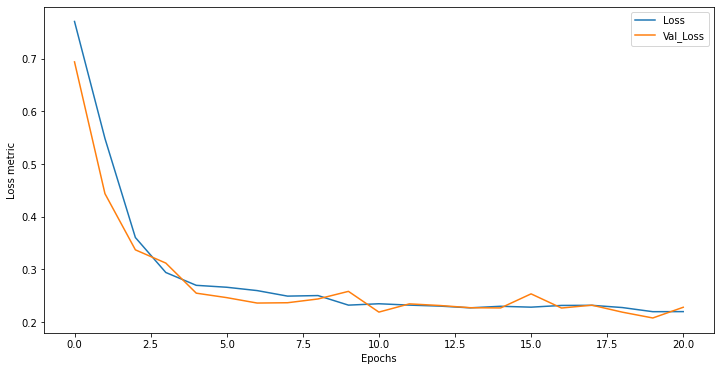

In [82]:
plt.figure(figsize = (12, 6))
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label = 'Loss')
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss metric')
plt.legend()
plt.show()

**Evaluate the model performance on the test set:**

In [83]:
img_model.metrics_names

['loss', 'accuracy']

In [84]:
img_model.evaluate(test_data_gen)

41/41 [==============================] - 13s 303ms/step - loss: 0.2279 - accuracy: 0.9200


[0.22786325216293335, 0.9200000166893005]

### 5. Make predictions on the Test data

In [85]:
prediction_probs = img_model.predict(test_data_gen)
prediction_probs

array([[6.5096479e-05],
       [3.1124600e-03],
       [1.0407582e-03],
       ...,
       [9.2230153e-01],
       [9.2240316e-01],
       [9.2240316e-01]], dtype=float32)

In [86]:
predictions = prediction_probs > 0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

**Create the Classification Report & Confusion Matrix over the predictions**

In [87]:
from sklearn.metrics import classification_report, confusion_matrix

In [88]:
print(classification_report(test_data_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1300
           1       0.91      0.94      0.92      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



In [89]:
print(confusion_matrix(test_data_gen.classes, predictions))

[[1173  127]
 [  83 1217]]


### 6. Check the predictions for a single image

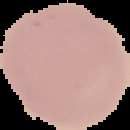

In [90]:
new_image = tf.keras.preprocessing.image.load_img(test_dir + 'Uninfected/' + os.listdir(test_dir + 'Uninfected/')[25],
                                                  target_size = image_shape)
new_image

In [91]:
new_image = tf.keras.preprocessing.image.img_to_array(new_image)
new_image

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [92]:
new_image.shape

(130, 130, 3)

**Expand the dims of the new_image to include the batch_size (in this case: 1, as we are predicting a single image:**

In [93]:
new_image = np.expand_dims(new_image, axis = 0)
new_image.shape

(1, 130, 130, 3)

**Now make the prediction:**

In [94]:
img_model.predict(new_image)

array([[1.]], dtype=float32)

In [95]:
test_data_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

**So, as seen in the original image, or while loading, this image is one of the Parasitized ones; and that is also being predicted by our model. So we can say our model is doing a pretty good job!** 